In [2]:
import os
import numpy as np
import pandas as pd

import scanpy as sc
import decoupler as dc
import liana as li
import squidpy as sq

import muon as mu

import plotnine as p9

/home/dbdimitrov/.local/lib/python3.8/site-packages/pynndescent/utils.py:205: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/dbdimitrov/.local/lib/python3.8/site-packages/pynndescent/utils.py:304: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [3]:
data_dir = os.path.join('..', '..', 'data', 'heart_visium')

In [4]:
dataset_names = [f for f in os.listdir(data_dir) if f.endswith('.h5ad')]

In [5]:
metadata = pd.read_csv(os.path.join("..", "spot_calling", "visium_meta.csv"))

In [6]:
# get IZ samples
metadata = metadata[metadata['major_labl']=='IZ']

## Agreement between Spatial and Single-cell

In [7]:
nmf_factor = 'Factor2'

In [8]:
lr_nmf = pd.read_csv(os.path.join('results', 'lr_loadings.csv'), index_col=0)
lr_dea = pd.read_csv(os.path.join('kuppe_dea_interactions.csv'))
lr_dea['interaction'] = lr_dea['ligand'] + '^' + lr_dea['receptor']
lr_dea.set_index('interaction', inplace=True)

In [9]:
lr_joint = lr_nmf.merge(lr_dea, how='inner', right_index=True, left_index=True).sort_values(nmf_factor, ascending=False).reset_index(names='interaction')

In [10]:
lr_joint['interaction_expr'] = (lr_joint['ligand_expr'] + lr_joint['receptor_expr'])/2

In [11]:
sig_ints = lr_joint[((lr_joint['receptor_padj']<=0.05) | (lr_joint['ligand_padj']<=0.05)) & ((lr_joint['ligand_stat']>0) & (lr_joint['receptor_stat']>0))]['interaction'].tolist()

/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_color_cmap could not recognise parameter `midpoint`
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


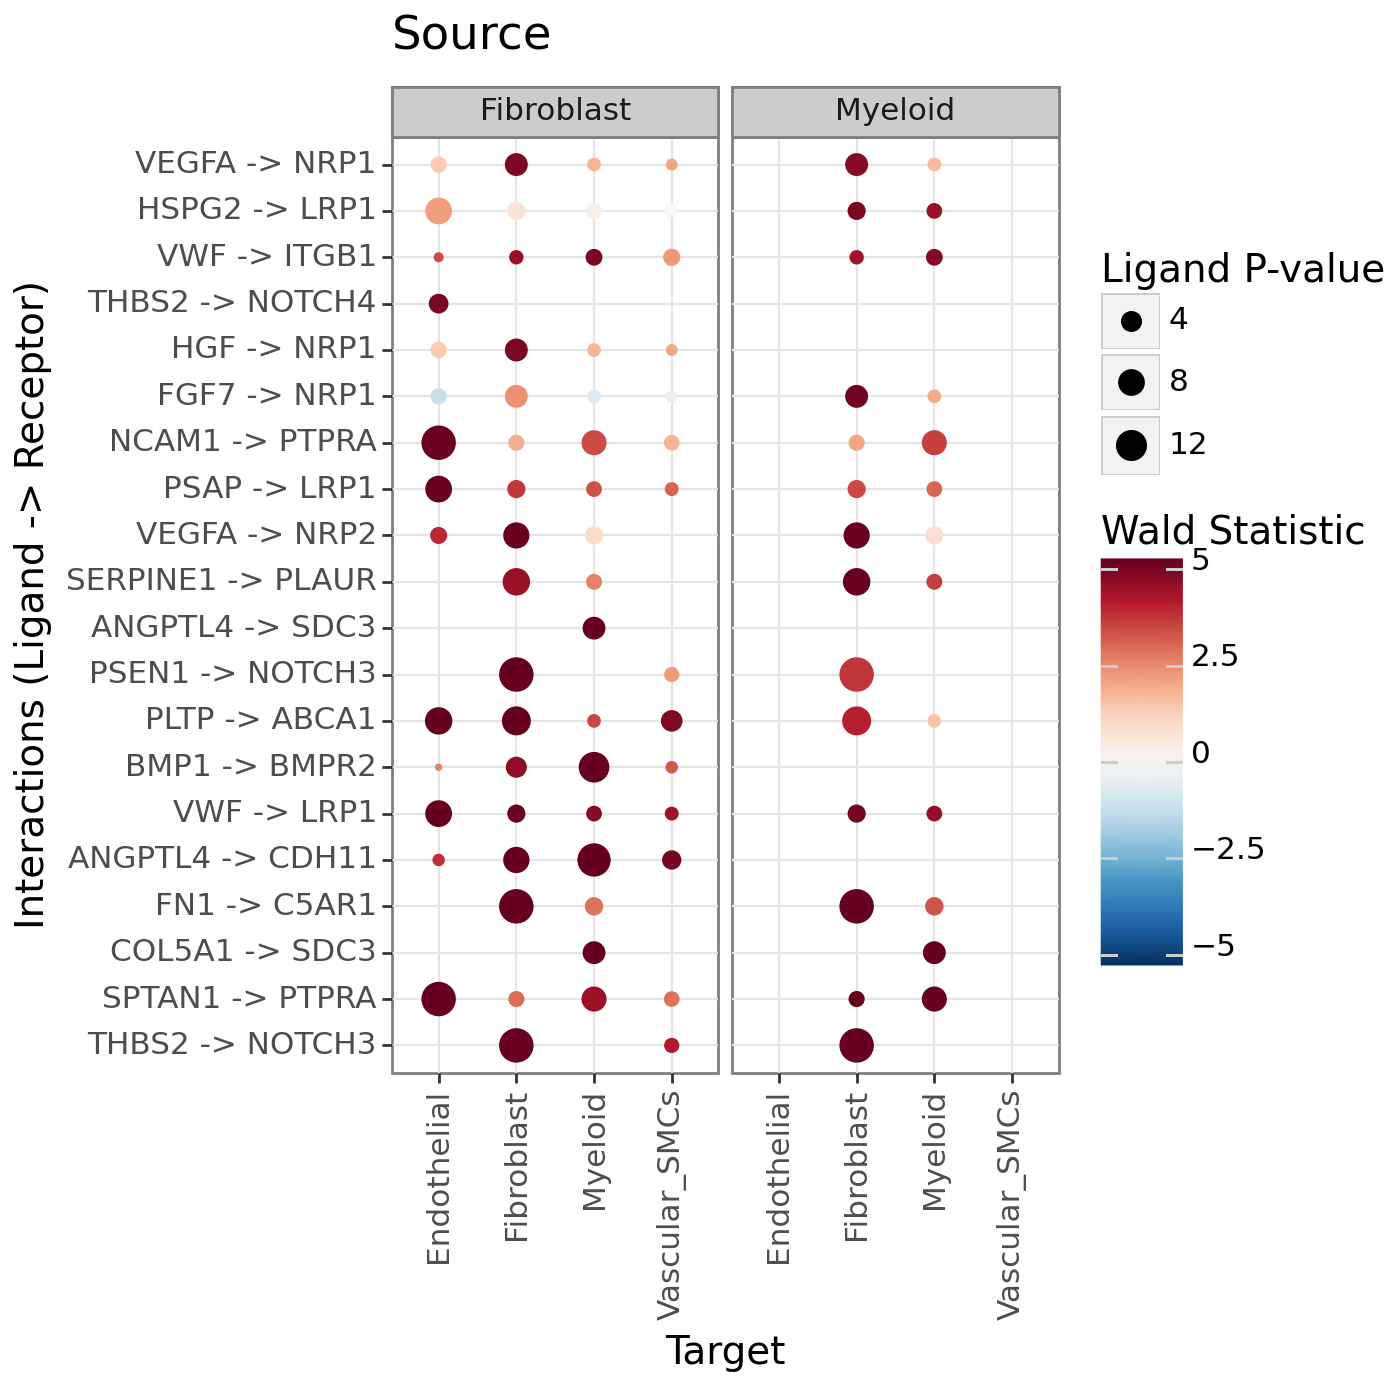

<Figure Size: (700 x 700)>

In [16]:
plot = li.pl.dotplot(liana_res=lr_joint[lr_joint['interaction'].isin(sig_ints)],
                     colour='interaction_stat',
                     size='receptor_pvalue',
                     size_range=(0.5, 6),
                     inverse_size=True,
                     orderby='interaction_stat',
                     orderby_ascending=False,
                     top_n=20,
                     source_labels=["Myeloid", "Fibroblast"],
                     )
# customize plot
(
    plot
    + p9.theme_bw(base_size=14)
    # fill cmap blue to red, + limits for colour and mid point
    + p9.scale_color_cmap('RdBu_r', limits=(-5, 5), midpoint=0)
    # rotate x
    + p9.theme(axis_text_x=p9.element_text(angle=90), figure_size=(7, 7)) +
    p9.labs(color='Wald Statistic', size='Ligand P-value')
)

In [42]:
# Replace  -> with ^
plot.data['interaction'] = plot.data['interaction'].str.replace(' -> ', '^')

In [43]:
top_features = list(plot.data['interaction'].unique())

In [44]:
top_features

['FN1^C5AR1',
 'SERPINE1^PLAUR',
 'COL1A2^CD44',
 'COL1A1^ITGA5',
 'BMP1^BMPR2',
 'COL5A1^SDC3',
 'ANGPTL4^SDC3',
 'THBS2^NOTCH4',
 'THBS2^NOTCH3',
 'PSEN1^NOTCH3',
 'ANGPTL4^CDH11',
 'LAMA5^DAG1',
 'COL18A1^ITGB5',
 'PLTP^ABCA1',
 'LAMB1^ITGA1',
 'PDGFA^PDGFRA',
 'SPTAN1^PTPRA',
 'HSPG2^LRP1',
 'VWF^LRP1',
 'PSAP^LRP1']

Pick this: 	Visium_7_CK285

In [18]:
metadata

slide_name patient patient_region_id patient_group major_labl batch  \
1     AKK002_157779      P3             IZ_P3       group_2         IZ   10X   
4     AKK003_157775      P2          IZ/BZ_P2       group_2         IZ   10X   
10  Visium_11_CK289     P13         GT/IZ_P13       group_2         IZ   ACH   
14  Visium_15_CK293     P16            IZ_P16       group_2         IZ   ACH   
17  Visium_18_CK296     P15         GT/IZ_P15       group_2         IZ   ACH   
18  Visium_19_CK297      P9     GT/IZ_P9_rep2       group_2         IZ   ACH   
20  Visium_20_CK298     P15            IZ_P15       group_2         IZ   ACH   
25   Visium_7_CK285     P10            IZ_P10       group_2         IZ   ACH   
27   Visium_9_CK287      P9          GT/IZ_P9       group_2         IZ   ACH   

   hca_sample_id  
1        10X0017  
4        10X0018  
10       ACH0010  
14       ACH0016  
17       ACH0011  
18       ACH0013  
20       ACH0015  
25       ACH0014  
27       ACH0012

In [19]:
# load collecTRI regulons
net = dc.get_collectri(organism='human')

Failed to download from `https://omnipathdb.org/`.
Traceback (most recent call last):
  File "/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/omnipath/_core/downloader/_downloader.py", line 143, in maybe_download
    res = self._download(req)
  File "/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/omnipath/_core/downloader/_downloader.py", line 181, in _download
    resp.raise_for_status()
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/requests/models.py", line 1021, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 500 Server Error: Internal Server Error for url: https://omnipathdb.org/queries/enzsub?format=json

Failed to download from `http://no-tls.omnipathdb.org/`.
Traceback (most recent call last):
  File "/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/omnipath/_core/downloader/_downloader.py", line 143, in maybe_download
    res = self._download(req)
 

In [20]:
sc.set_figure_params(fontsize=16, figsize=(8, 8), frameon=False)

Read in H loadings from NMF

In [21]:
# read tf csv
tfs = pd.read_csv('kuppe_tf_activities.csv')
tfs = tfs[tfs['fdr'] < 0.05]['tf'].unique()
tfs

array(['AHR', 'AP1', 'ASCL1', 'CEBPB', 'CEBPG', 'CREB1', 'CTNNB1',
       'DNMT1', 'E2F1', 'EGR1', 'ELK1', 'EPAS1', 'ERG', 'ESR1', 'ETS1',
       'ETS2', 'ETV4', 'EZH2', 'FLI1', 'FOS', 'FOXM1', 'FOXN1', 'HIF1A',
       'HMGA1', 'HOXA1', 'HR', 'ID3', 'IRF8', 'JUN', 'KLF5', 'MITF',
       'MYB', 'MYC', 'MYCN', 'MYOD1', 'MYRF', 'NFATC1', 'NFIC', 'NFKB',
       'NFKB1', 'NR1I2', 'NRG1', 'PAX6', 'POU2F1', 'RARA', 'REL', 'RELA',
       'RUNX1', 'SCX', 'SMAD1', 'SMAD2', 'SMAD3', 'SMAD4', 'SNAI1', 'SP1',
       'SP3', 'SP7', 'SPI1', 'SRF', 'SSRP1', 'STAT1', 'STAT3', 'STAT6',
       'TCF3', 'TCF7', 'TCF7L2', 'TFAP2A', 'TFE3', 'TP53', 'TP63', 'TP73',
       'TWIST1', 'USF1', 'USF2', 'VDR', 'YBX1', 'ZBTB7A', 'CIITA',
       'HIVEP2', 'RFX5', 'RFXANK', 'JUND', 'MXD1', 'ZNF384', 'IRF3',
       'LMO2'], dtype=object)

Load files, join to MuData

In [49]:
mdatas = {}
target_metrics = {}
interactions = {}

for sample in metadata['slide_name']:
    print(f"Now running: {sample}")
    
    # TODO when calculating medians for plots, impute missing values as 0
    
    lr = sc.read_h5ad(os.path.join('results', 'lr', sample + '.h5ad'))
    msk = lr.var.index[lr.var_names.isin(top_features)]
    lr = lr[:, msk]
    
    # run TF enrichment
    adata = sc.read_h5ad(os.path.join('results', 'processed', sample + '.h5ad'))
    
    # NOTE: here we exclude the diagonal (given we want to predict the intra with surrounding spots)
    li.ut.spatial_neighbors(adata, bandwidth=150, set_diag=False, cutoff=0.05)
    
    dc.run_ulm(adata,
               net,
               source="source", target="target",
               use_raw=False, min_n=5)
    tf = li.ut.obsm_to_adata(adata, 'ulm_estimate')
    # exract compositions
    comp = li.ut.obsm_to_adata(adata, 'compositions')
    comp = comp[:, comp.var.index!='prolif']
    
    # Build misty views and run MISTy
    mdata = mu.MuData({"intra": lr.copy(), "comp":comp.copy(), "tf":tf[:,tfs].copy()})
    mu.pp.intersect_obs(mdata)
    misty = li.mt.MistyData(mdata)
    misty(model='linear', verbose=True, bypass_intra=True)
    
    target_metrics[sample] = misty.uns['target_metrics']
    interactions[sample] = misty.uns['interactions']
    
    mdatas[sample] = mdata

Now running: AKK002_157779


view intra is not a csr_matrix. Converting to csr_matrix
view comp is not a csr_matrix. Converting to csr_matrix
view tf is not a csr_matrix. Converting to csr_matrix
Now learning: ANGPTL4^CDH11: 100%|██████████| 19/19 [00:34<00:00,  1.84s/it] 


Now running: AKK003_157775


view intra is not a csr_matrix. Converting to csr_matrix
view comp is not a csr_matrix. Converting to csr_matrix
view tf is not a csr_matrix. Converting to csr_matrix
Now learning: ANGPTL4^CDH11: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it] 


Now running: Visium_11_CK289


view intra is not a csr_matrix. Converting to csr_matrix
view comp is not a csr_matrix. Converting to csr_matrix
view tf is not a csr_matrix. Converting to csr_matrix
Now learning: ANGPTL4^CDH11: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s] 


Now running: Visium_15_CK293


view intra is not a csr_matrix. Converting to csr_matrix
view comp is not a csr_matrix. Converting to csr_matrix
view tf is not a csr_matrix. Converting to csr_matrix
Now learning: ANGPTL4^CDH11: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it] 


Now running: Visium_18_CK296


view intra is not a csr_matrix. Converting to csr_matrix
view comp is not a csr_matrix. Converting to csr_matrix
view tf is not a csr_matrix. Converting to csr_matrix
Now learning: ANGPTL4^CDH11: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it] 


Now running: Visium_19_CK297


view intra is not a csr_matrix. Converting to csr_matrix
view comp is not a csr_matrix. Converting to csr_matrix
view tf is not a csr_matrix. Converting to csr_matrix
Now learning: ANGPTL4^CDH11: 100%|██████████| 20/20 [00:39<00:00,  1.98s/it] 


Now running: Visium_20_CK298


view intra is not a csr_matrix. Converting to csr_matrix
view comp is not a csr_matrix. Converting to csr_matrix
view tf is not a csr_matrix. Converting to csr_matrix
Now learning: ANGPTL4^CDH11: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it] 


Now running: Visium_7_CK285


view intra is not a csr_matrix. Converting to csr_matrix
view comp is not a csr_matrix. Converting to csr_matrix
view tf is not a csr_matrix. Converting to csr_matrix
Now learning: PLTP^ABCA1: 100%|██████████| 17/17 [00:28<00:00,  1.70s/it]    


Now running: Visium_9_CK287


view intra is not a csr_matrix. Converting to csr_matrix
view comp is not a csr_matrix. Converting to csr_matrix
view tf is not a csr_matrix. Converting to csr_matrix
Now learning: ANGPTL4^CDH11: 100%|██████████| 18/18 [00:35<00:00,  1.97s/it]


In [50]:
targets = pd.concat(target_metrics).reset_index().rename(columns={'level_0':'sample'}).drop(columns='level_1').copy()
targets.to_csv(os.path.join("results", "misty_targets.csv"))

In [51]:
ints = pd.concat(interactions).reset_index().rename(columns={'level_0':'sample'}).drop(columns='level_1').copy()
ints.to_csv(os.path.join("results", "misty_interactions.csv"))

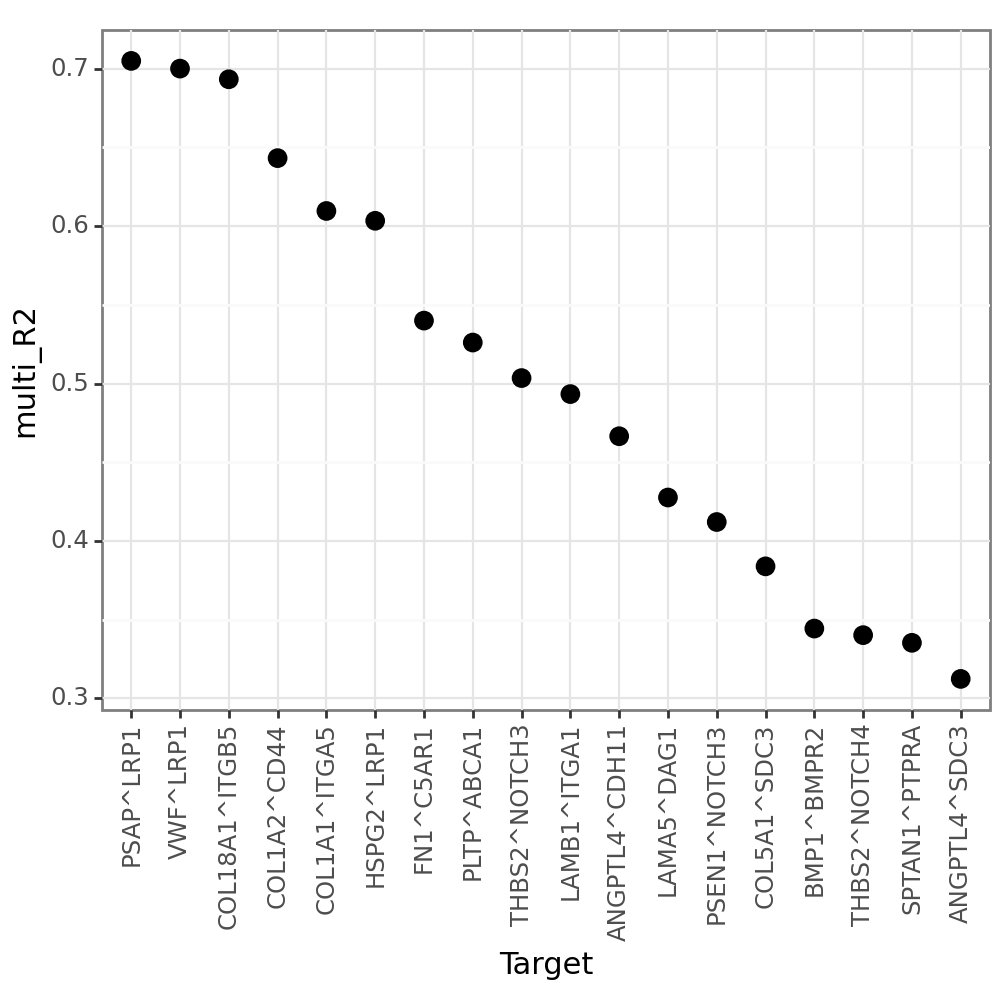

<Figure Size: (500 x 500)>

In [52]:
li.pl.target_metrics(misty, stat='multi_R2', return_fig=True, figure_size=(5, 5))

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


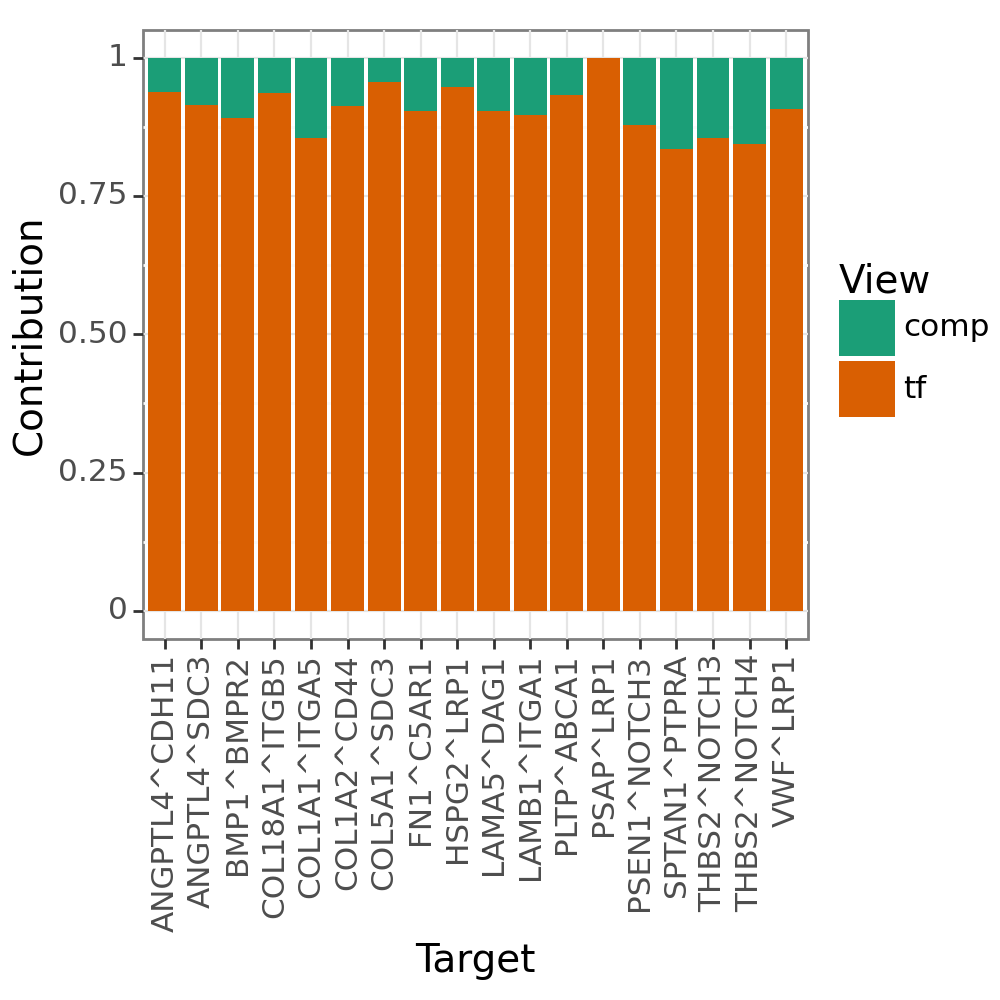

<Figure Size: (500 x 500)>

In [53]:
li.pl.contributions(misty, return_fig=True, figure_size=(5, 5))

In [54]:
interactions = misty.uns['interactions'].copy()

In [55]:
interactions[interactions['view']=='tf'].sort_values("importances", ascending=False).head(15)

target predictor view  importances
3281     PLTP^ABCA1     DNMT1   tf    13.920048
2452   COL1A1^ITGA5      PAX6   tf    12.304140
1846       VWF^LRP1       ERG   tf    11.932702
3346     PLTP^ABCA1      USF1   tf    11.621531
3370  ANGPTL4^CDH11       AHR   tf   -10.717358
2541  COL18A1^ITGB5      MYRF   tf    10.272093
3210     BMP1^BMPR2       MYC   tf    10.027059
2510  COL18A1^ITGB5     CEBPG   tf     9.597679
2916    LAMB1^ITGA1       ID3   tf    -9.589369
2519  COL18A1^ITGB5      ESR1   tf     9.536169
2269   THBS2^NOTCH3     SMAD3   tf     9.464320
3233     BMP1^BMPR2       SP3   tf    -9.449374
2864      FN1^C5AR1      TP73   tf    -9.446100
2363   PSEN1^NOTCH3     SMAD1   tf    -9.418401
2040      PSAP^LRP1      ETS1   tf    -9.384800

Plot sample averages

In [56]:
import plotnine as p9

In [57]:
ints = pd.read_csv(os.path.join("results", "misty_interactions.csv"), index_col=0)
targets = pd.read_csv(os.path.join("results", "misty_targets.csv"), index_col=0)

Contributions

In [58]:
contributions = targets[['target', 'tf', 'comp', 'sample']].melt(id_vars=['target', 'sample'], var_name='view', value_name='contribution').copy()

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


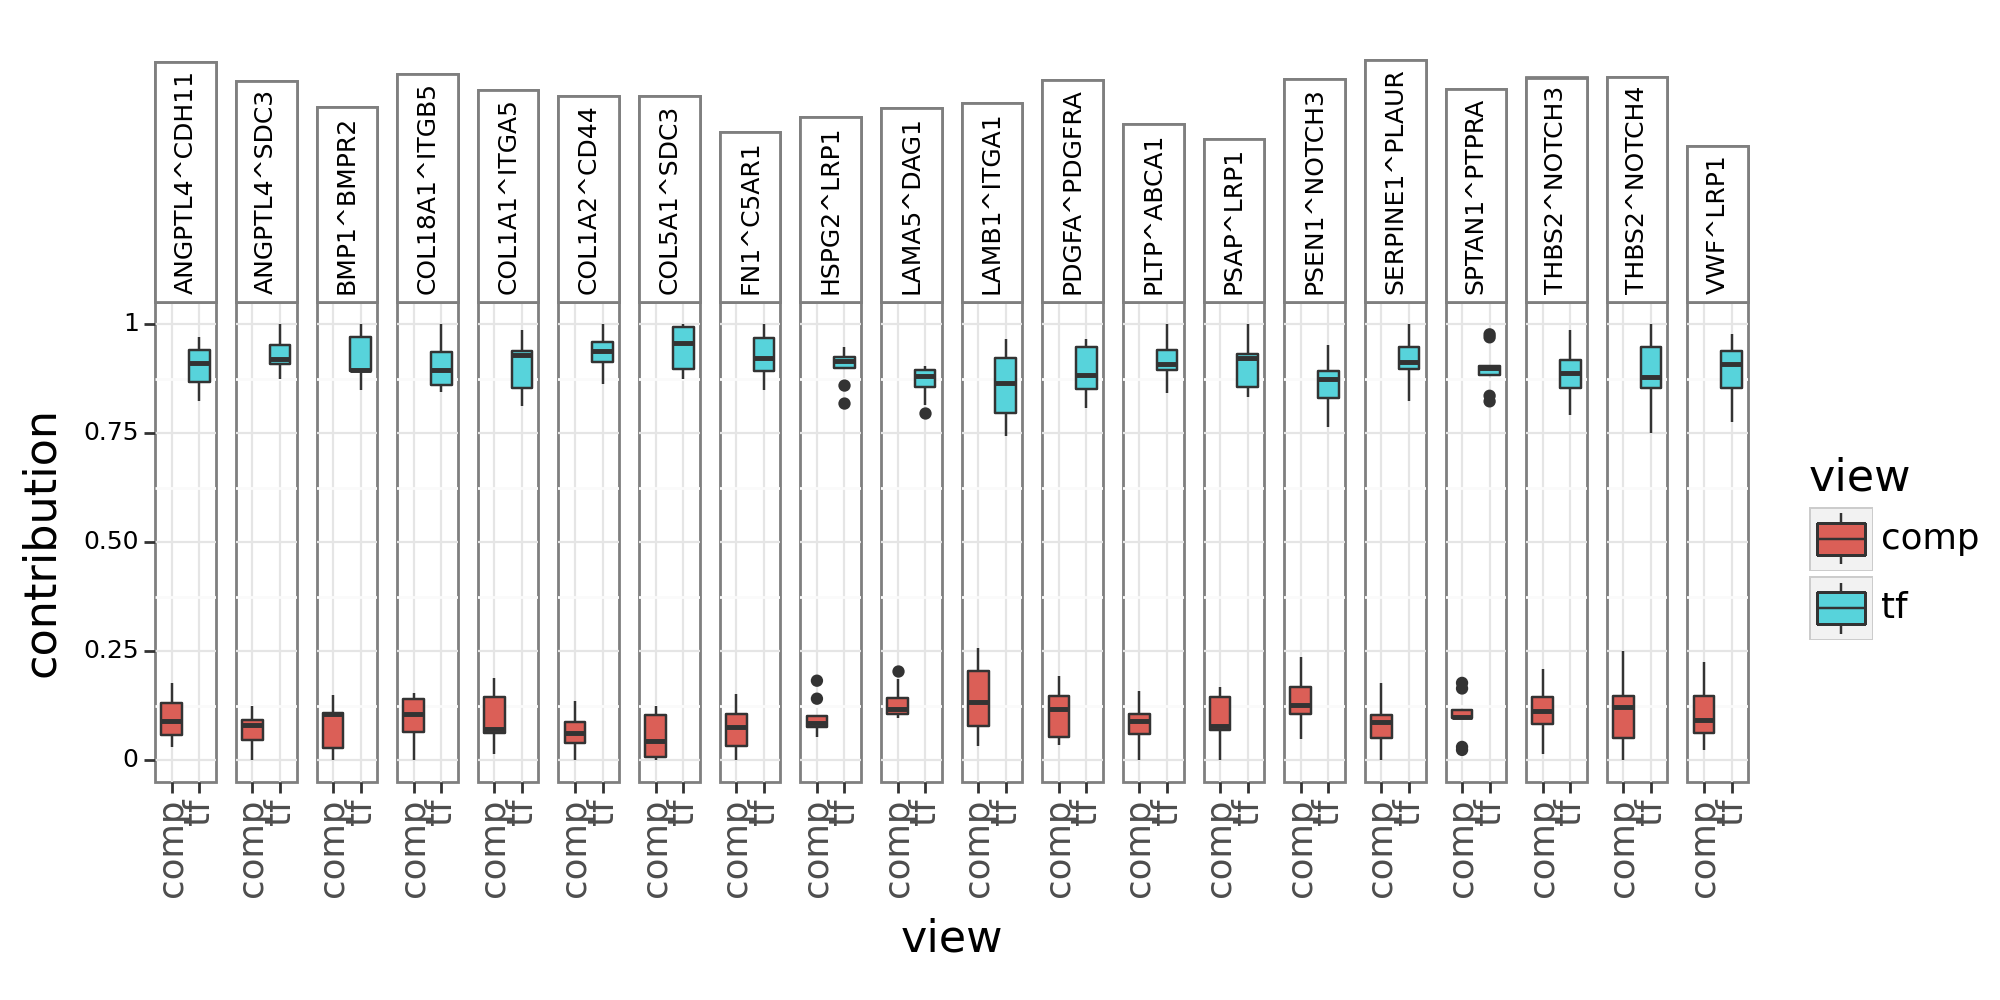

<Figure Size: (1000 x 500)>

In [59]:
### boxplot, ~target, x=view, y=contribution

(
    p9.ggplot(contributions, p9.aes(x='view', y='contribution', fill='view')) +
    p9.geom_boxplot() +
    p9.facet_wrap('~ target', nrow=1) +
    p9.theme_bw(base_size=16) +
    p9.theme(axis_text_x=p9.element_text(rotation=90),
             figure_size=(10, 5),
             strip_background=p9.element_rect(fill="white"),
             strip_text=p9.element_text(size=9, colour="black", rotation=90),
             axis_text_y=p9.element_text(size=9, colour="black"),
             )
    # flip coord
)

#### R2 multi

In [60]:
targets.groupby('target').mean().sort_values('multi_R2', ascending=False).head(10)

/tmp/ipykernel_61929/3918919098.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


intra_R2  multi_R2   gain_R2      comp        tf
target                                                         
COL1A2^CD44         0.0  0.738254  0.738254  0.060139  0.939861
HSPG2^LRP1          0.0  0.711904  0.711904  0.096779  0.903221
PSAP^LRP1           0.0  0.711507  0.711507  0.095687  0.904313
COL18A1^ITGB5       0.0  0.709812  0.709812  0.094800  0.905200
COL1A1^ITGA5        0.0  0.706643  0.706643  0.096420  0.903580
VWF^LRP1            0.0  0.703927  0.703927  0.105089  0.894911
FN1^C5AR1           0.0  0.677693  0.677693  0.078751  0.921249
THBS2^NOTCH3        0.0  0.667502  0.667502  0.119566  0.880434
ANGPTL4^CDH11       0.0  0.624095  0.624095  0.095504  0.904496
COL5A1^SDC3         0.0  0.616713  0.616713  0.056532  0.943468

## Plot Averages across slides

In [76]:
interaction = 'BMP1^BMPR2'

In [77]:
ints[ints['view']=='tf'].groupby(['target', 'predictor']).agg({"importances":"median"}).sort_values("importances")

importances
target         predictor             
SERPINE1^PLAUR ETV4         -5.565105
THBS2^NOTCH4   SCX          -5.534246
COL18A1^ITGB5  NFKB1        -4.761642
ANGPTL4^SDC3   NFKB1        -4.593238
VWF^LRP1       FLI1         -4.446932
...                               ...
THBS2^NOTCH3   SP7           4.974128
THBS2^NOTCH4   ETV4          5.074479
PLTP^ABCA1     STAT1         5.171308
THBS2^NOTCH3   SMAD3         5.941676
VWF^LRP1       ERG           6.198963

[1720 rows x 1 columns]

In [78]:
### boxplot of tf view
sum_ints = ints.dropna().copy()

In [79]:
# mean and std
sum_ints = sum_ints.groupby(['target', 'view', 'predictor']).agg({'importances':['mean', 'std', 'median']}).reset_index()
# reset names
sum_ints.columns = ['target', 'view', 'predictor', 'mean', 'std', 'median']

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


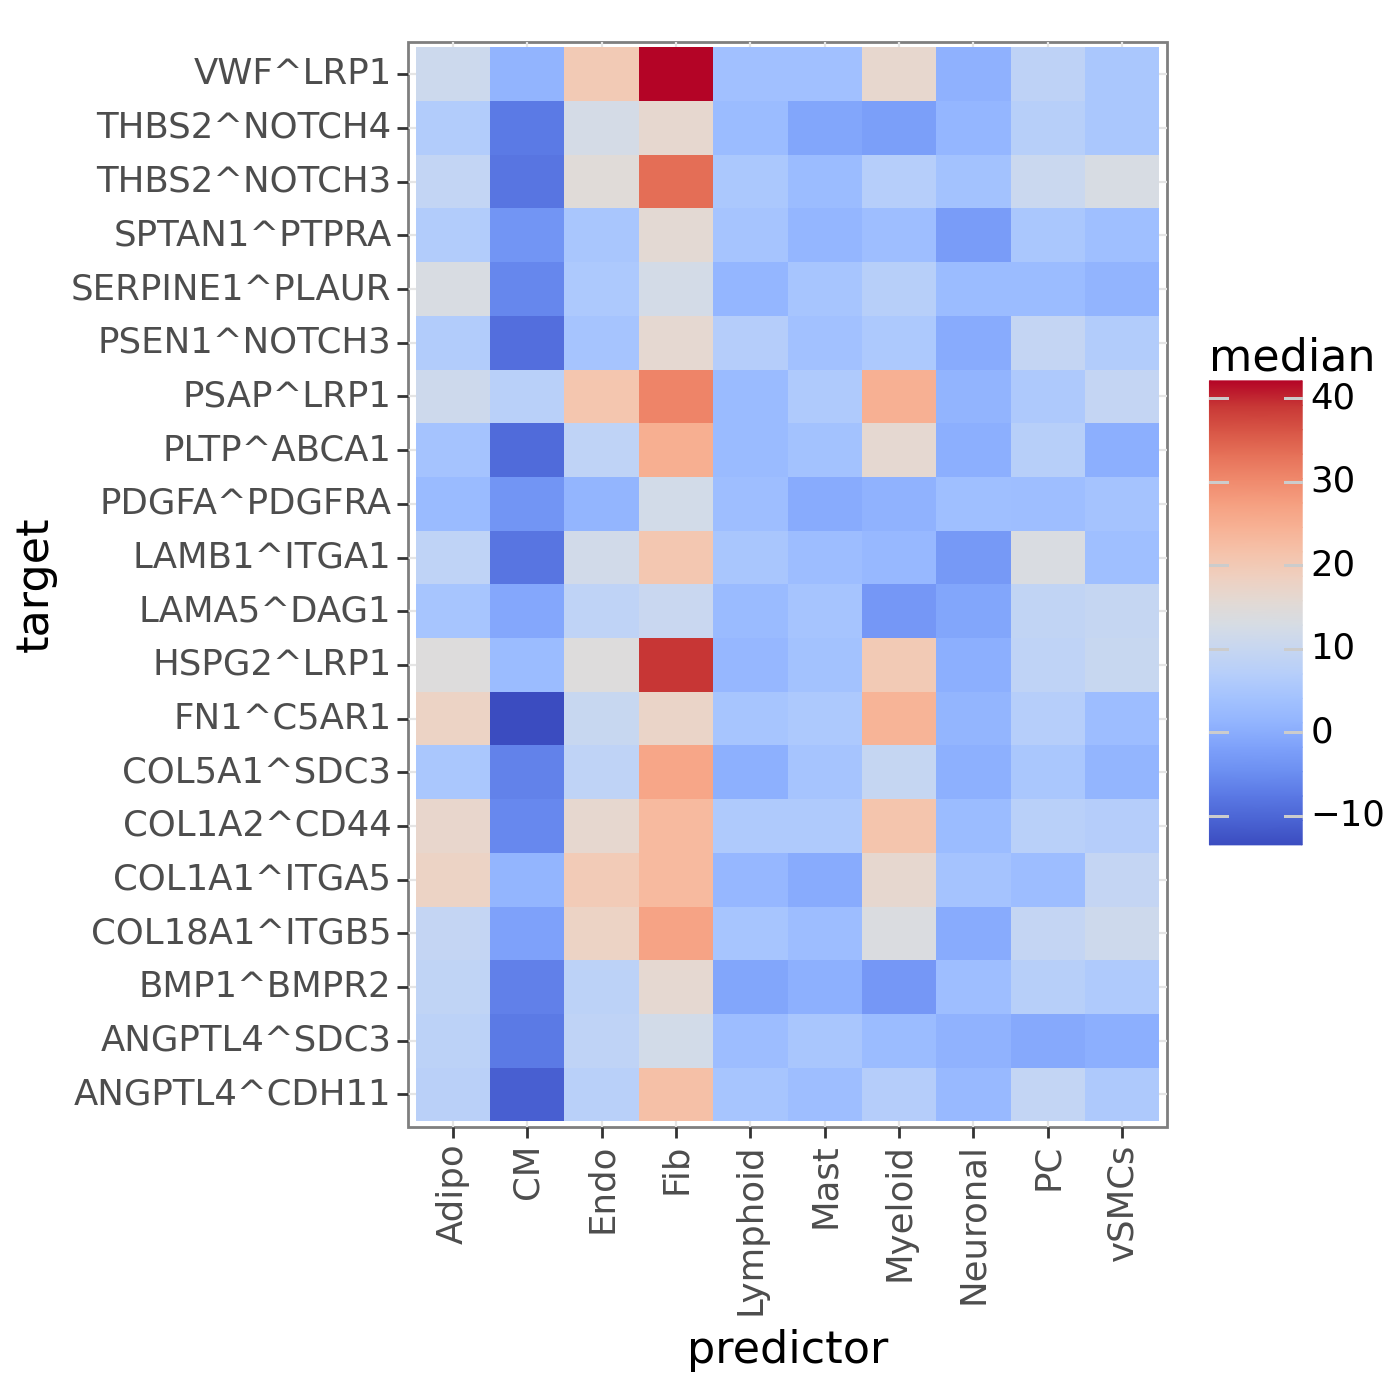

<Figure Size: (700 x 700)>

In [80]:
# heatmap
(
    p9.ggplot(sum_ints[(sum_ints['view']=='comp')], p9.aes(x='predictor', y='target', fill='median')) + 
    p9.geom_tile() +
    p9.theme_bw(base_size=16) +
    p9.theme(axis_text_x=p9.element_text(angle=90)) +
    p9.scale_fill_cmap('coolwarm') +
    p9.theme(figure_size=(7, 7))
)

Top TFs

In [81]:
sum_ints['target'].unique()

array(['ANGPTL4^CDH11', 'ANGPTL4^SDC3', 'BMP1^BMPR2', 'COL18A1^ITGB5',
       'COL1A1^ITGA5', 'COL1A2^CD44', 'COL5A1^SDC3', 'FN1^C5AR1',
       'HSPG2^LRP1', 'LAMA5^DAG1', 'LAMB1^ITGA1', 'PDGFA^PDGFRA',
       'PLTP^ABCA1', 'PSAP^LRP1', 'PSEN1^NOTCH3', 'SERPINE1^PLAUR',
       'SPTAN1^PTPRA', 'THBS2^NOTCH3', 'THBS2^NOTCH4', 'VWF^LRP1'],
      dtype=object)

In [82]:
top_predictors = sum_ints[sum_ints['target']==interaction].sort_values('median', ascending=False, key=abs)

In [83]:
top_predictors = top_predictors[top_predictors['view']=='tf'].head(25)['predictor'].unique()

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


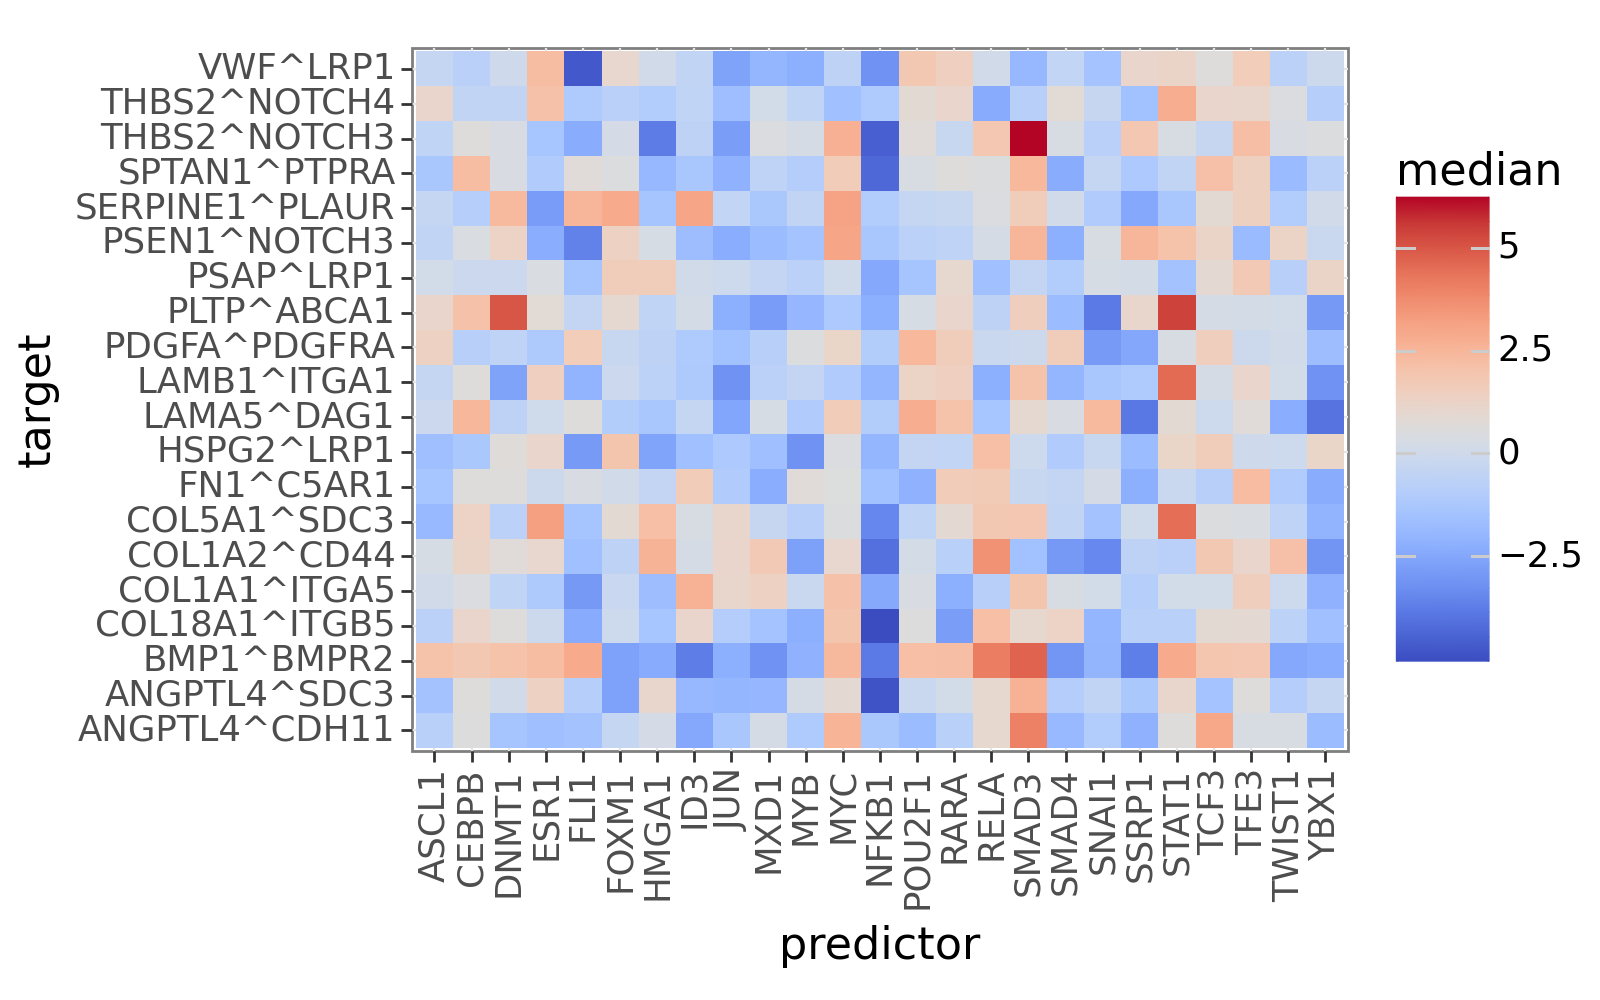

<Figure Size: (800 x 500)>

In [84]:
# heatmap
(
    p9.ggplot(sum_ints[sum_ints['predictor'].isin(top_predictors)],
              p9.aes(x='predictor', y='target', fill='median')) + 
    p9.geom_tile() +
    p9.theme_bw(base_size=16) +
    p9.theme(axis_text_x=p9.element_text(angle=90)) +
    p9.scale_fill_cmap('coolwarm') +
    p9.theme(figure_size=(8, 5))
)

Boxplot of top predictors for interaction x

In [85]:
top_ints = sum_ints[sum_ints['target']==interaction].sort_values("median", key=abs, ascending=False).head(15)

In [86]:
top_predictors = top_ints['predictor'].values

In [87]:
top_ints = ints[(ints['target']==interaction) & (ints['predictor'].isin(top_predictors))].copy()

In [88]:
top_ints['predictor'] = pd.Categorical(top_ints['predictor'], categories=top_predictors, ordered=True)

In [89]:
top_ints['view'].replace({'tf': 'Regulator', 'comp': 'Cell type'}, inplace=True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


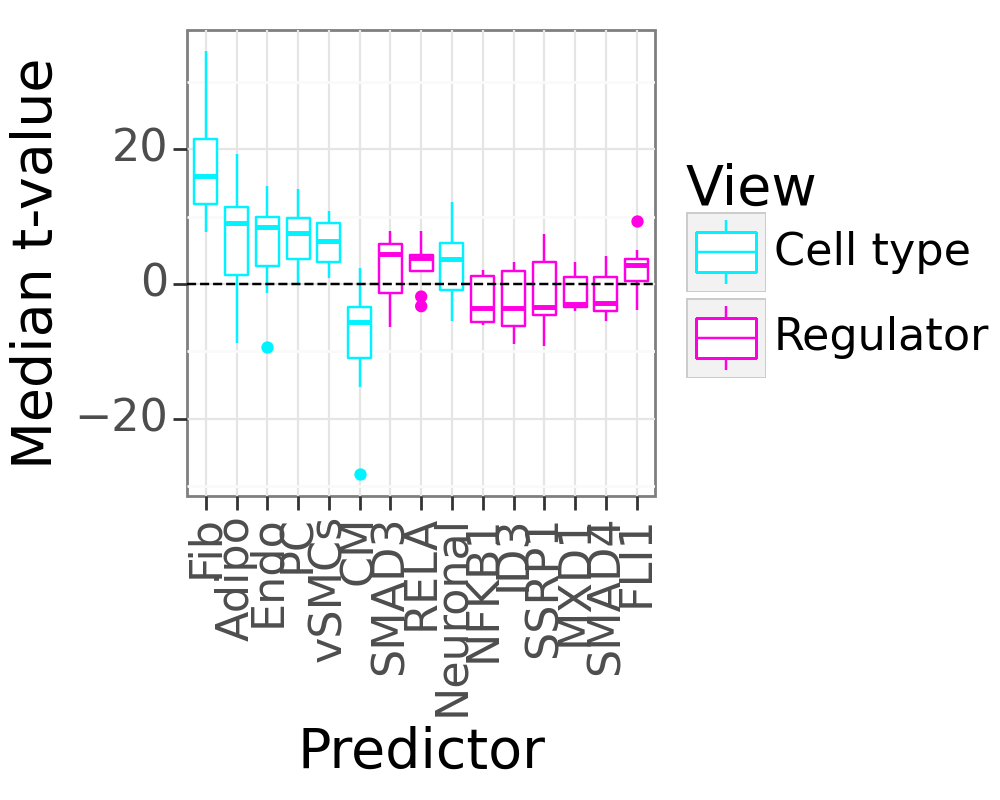

<Figure Size: (500 x 400)>

In [90]:
### boxplot
(
    p9.ggplot(top_ints, p9.aes(x='predictor', y='importances', colour='view')) +
    p9.geom_boxplot() +
    p9.theme_bw(base_size = 20) +
    p9.theme(axis_text_x=p9.element_text(rotation=90), figure_size=(5, 4)) +
    # labels
    p9.labs(x='Predictor', y='Median t-value', color='View') +
    # neon palette two colours
    p9.scale_colour_manual(values=['#00F3FF', '#FF00E4']) +
    p9.geom_hline(yintercept=0, linetype='dashed', color='black')
)

In [91]:
sum_ints[(sum_ints['target']==interaction) & (sum_ints['view']=='tf')].sort_values('median').tail(20)

target view predictor      mean       std    median
224  BMP1^BMPR2   tf     FOXN1  0.367156  3.027036  0.969614
260  BMP1^BMPR2   tf     SMAD2  0.251297  4.015501  1.208484
234  BMP1^BMPR2   tf      JUND  0.287601  3.085338  1.219812
225  BMP1^BMPR2   tf     HIF1A  0.508742  3.016919  1.474624
249  BMP1^BMPR2   tf      NRG1  0.970820  3.306759  1.579465
276  BMP1^BMPR2   tf    TFAP2A  1.447817  3.377797  1.739698
203  BMP1^BMPR2   tf       AP1  2.228720  3.872069  1.793063
205  BMP1^BMPR2   tf     CEBPB  1.390016  4.284066  1.793567
277  BMP1^BMPR2   tf      TFE3  2.447504  3.326475  1.842292
273  BMP1^BMPR2   tf      TCF3  2.016622  3.986440  1.851318
210  BMP1^BMPR2   tf     DNMT1 -0.085907  4.086620  1.974528
204  BMP1^BMPR2   tf     ASCL1  0.692232  4.016518  1.995234
251  BMP1^BMPR2   tf    POU2F1  2.260195  2.359214  2.119909
252  BMP1^BMPR2   tf      RARA  1.495089  2.492055  2.148955
216  BMP1^BMPR2   tf      ESR1  1.742898  3.386348  2.200318
240  BMP1^BMPR2   tf       MYC  1.752009  5.028006  2.311268
270  BMP1^BMPR2   tf     STAT1  0.840985  3.345930  2.776196
221  BMP1^BMPR2   tf      FLI1  2.572483  3.593978  2.802554
254  BMP1^BMPR2   tf      RELA  2.711812  3.424104  3.937358
261  BMP1^BMPR2   tf     SMAD3  2.378388  4.859113  4.520954

Example Slide

In [22]:
mdatas.keys()

NameError: name 'mdatas' is not defined

In [23]:
slide = 'Visium_7_CK285'
comp = 'Fib'
tf = 'RELA'
xy_sep = "<->"

In [108]:
import re

In [109]:
mdata = mdatas[slide].copy()

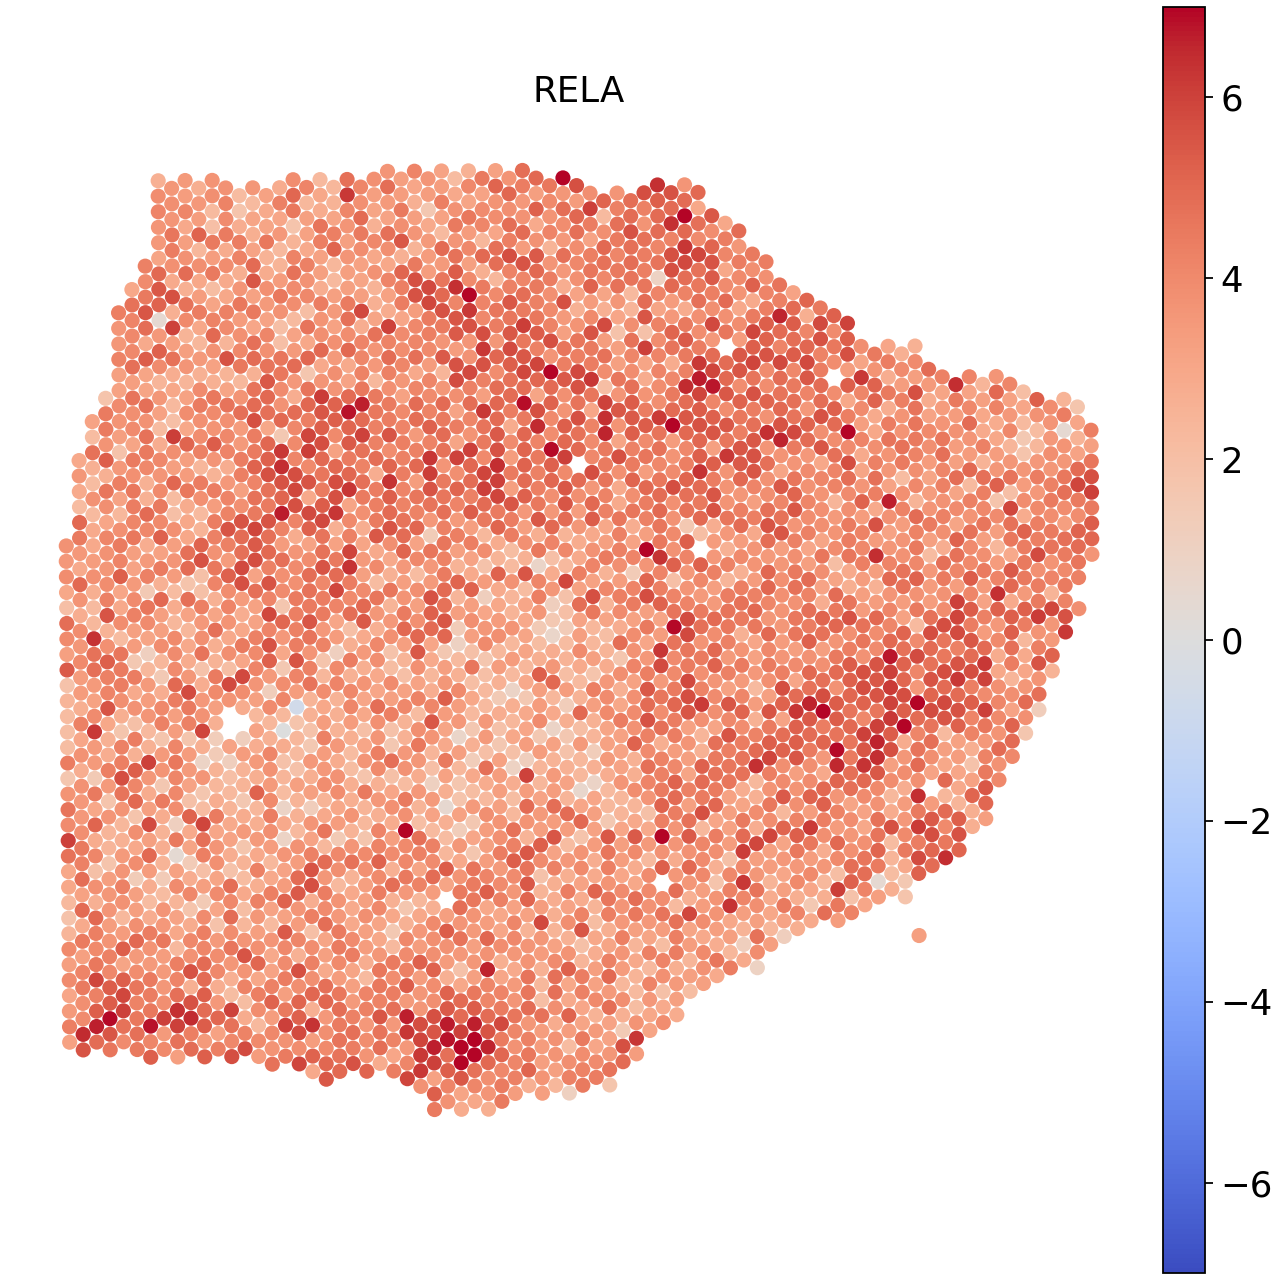

In [110]:
sq.pl.spatial_scatter(mdata.mod['tf'], color=tf, cmap="coolwarm", img=False, size=1.5, vmin=-7, vmax=7)
                      

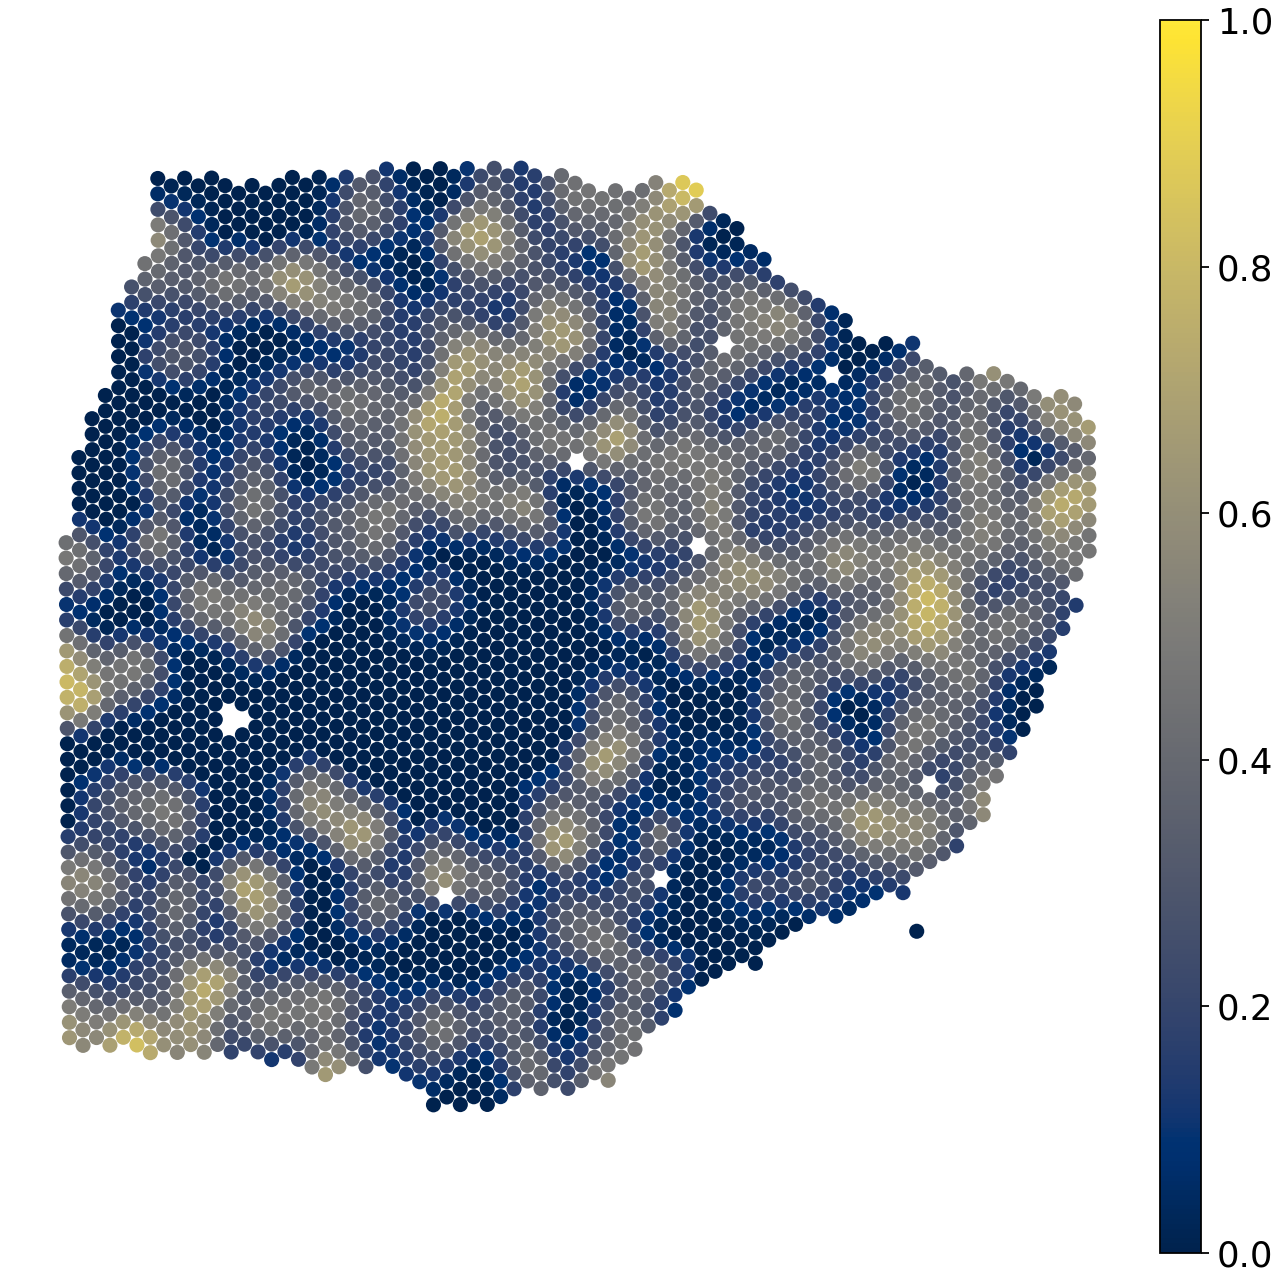

In [111]:
sq.pl.spatial_scatter(mdata.mod['intra'], color=interaction, cmap="cividis", img=False, size=1.5, vmax=1, vmin=0, title="")

In [24]:
data_dir = os.path.join('..', '..', 'data', 'heart_visium')
import sys
sys.path.append(os.path.join('..', 'spot_calling'))
from utils import load_prep_slide

In [25]:
slide = "Visium_7_CK285"

In [26]:
adata = load_prep_slide(data_dir, slide + '.h5ad')

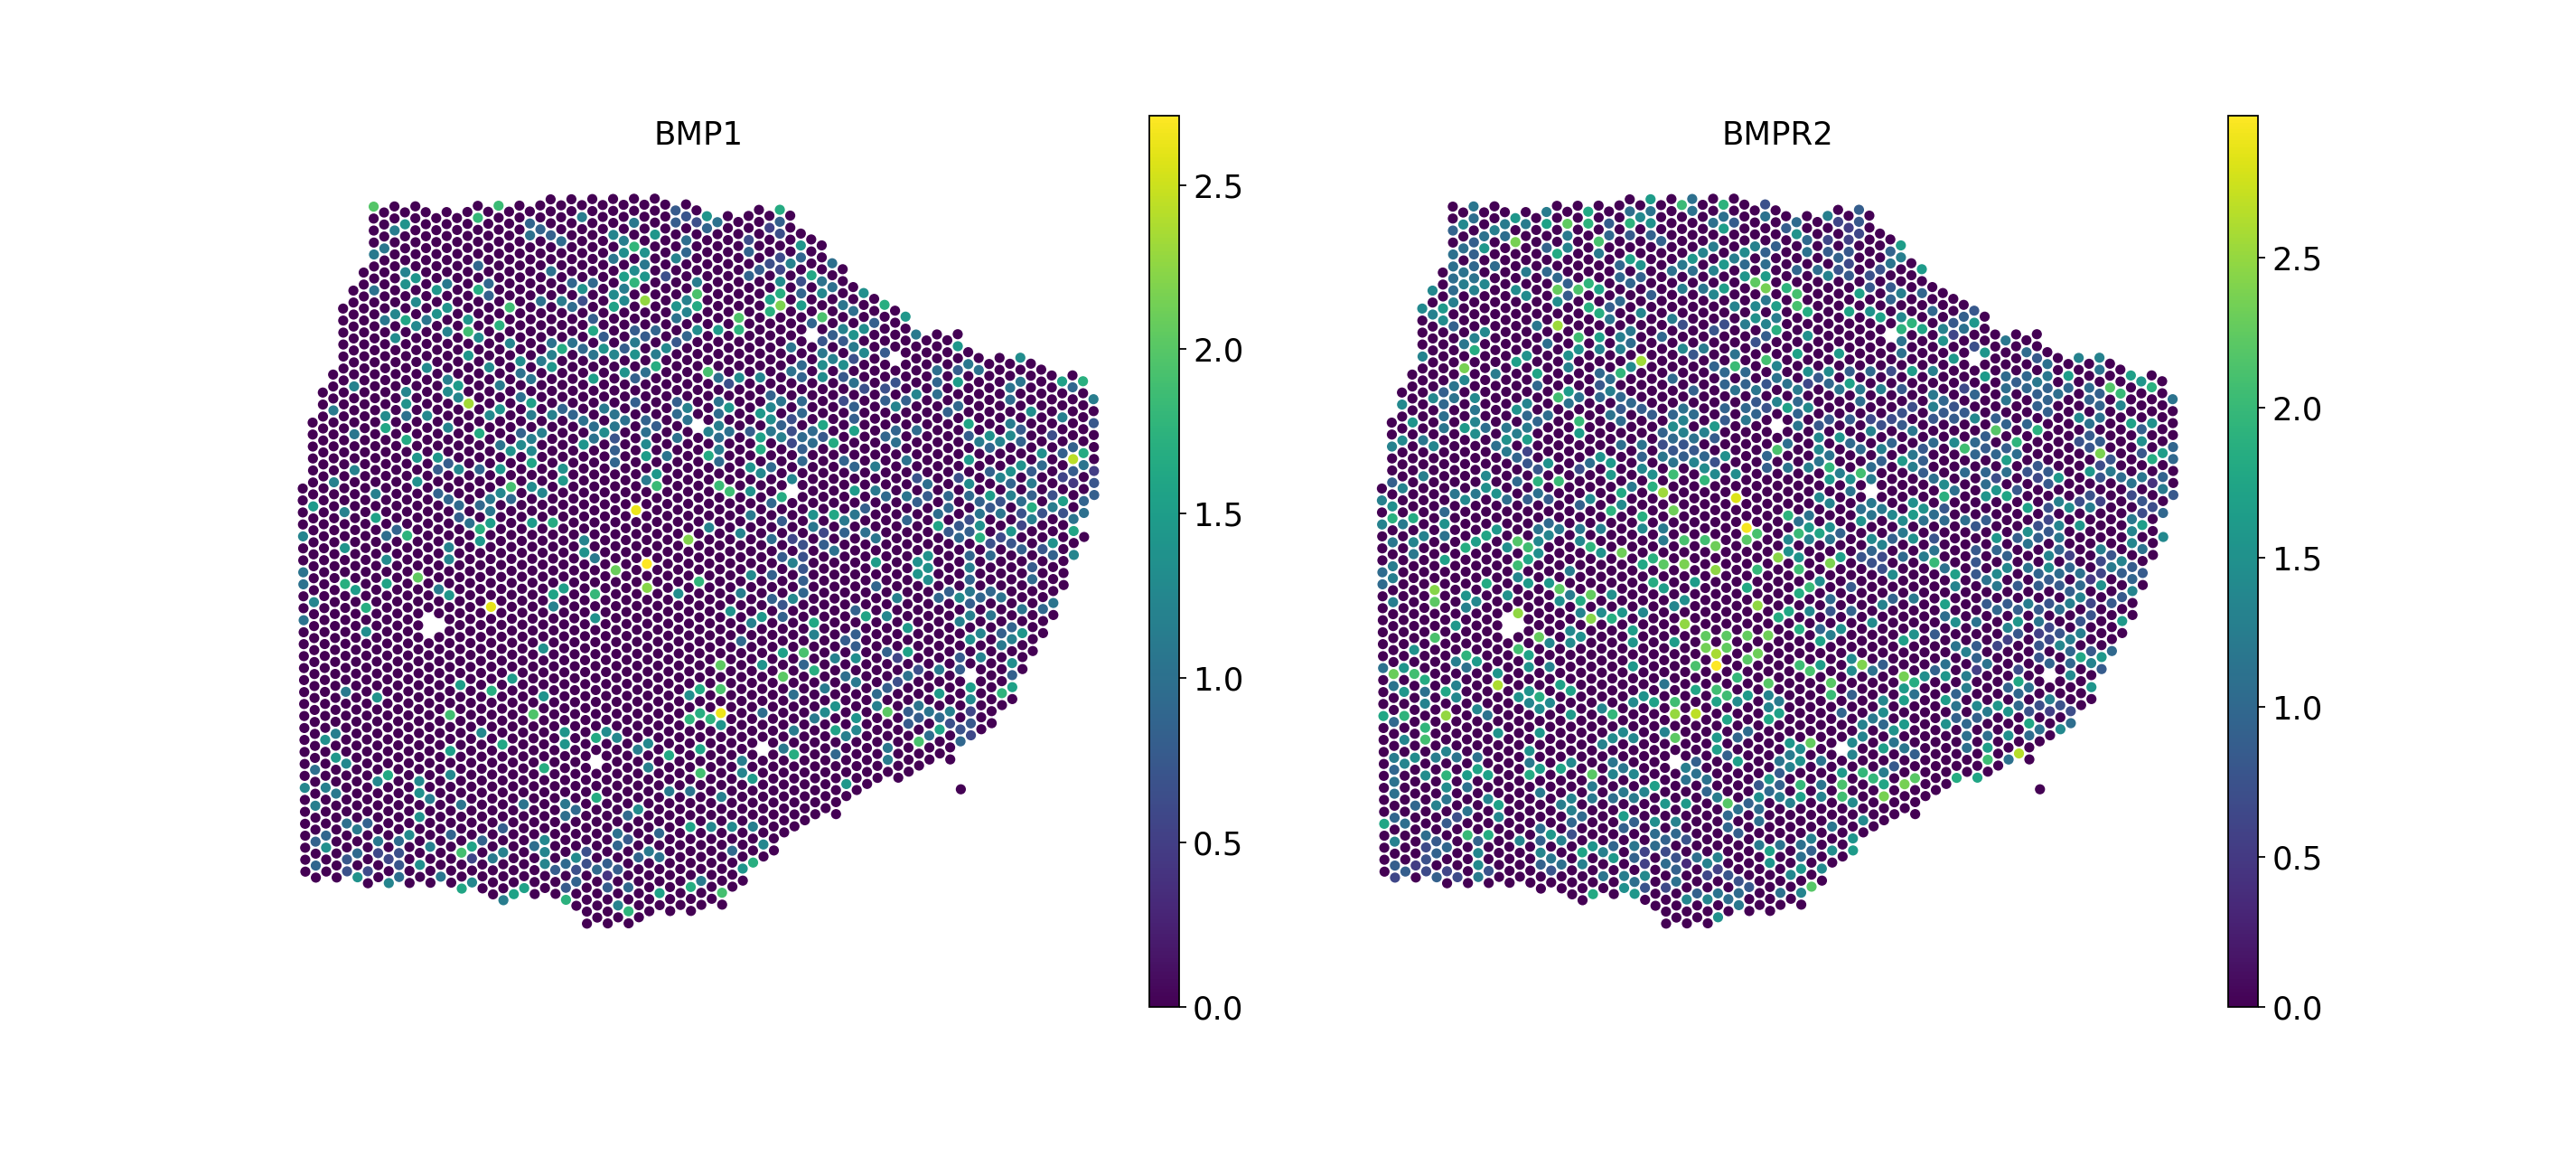

In [27]:
sq.pl.spatial_scatter(adata, color=['BMP1', 'BMPR2'], img=False, size=1.3)

BASIS

In [28]:
lrdata = mdata.mod['intra'].copy()

NameError: name 'mdata' is not defined

In [29]:
mdata.obsm = lrdata.obsm.copy()
mdata.uns = lrdata.uns.copy()
mdata.obsp = lrdata.obsp.copy()

NameError: name 'lrdata' is not defined

In [145]:
li.mt.bivar(mdata,
            function_name='cosine',
            x_mod='tf',
            y_mod='intra',
            x_transform=sc.pp.scale,
            y_transform=sc.pp.scale,
            interactions=[(tf, interaction)],
            mask_negatives=True, 
            add_categories=True,
            n_perms=100,
            complex_sep=None,
            xy_sep='<->',
            x_use_raw=False,
            y_use_raw=False,
            )

In [ ]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], color=f'{tf}{xy_sep}{interaction}', cmap="coolwarm", img_alpha=0, size=1.5, title="", vmin=-1, vmax=1)

In [ ]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], layer='cats', color=f'{tf}{xy_sep}{interaction}', cmap="coolwarm", img_alpha=0, size=1.5, title="")

In [ ]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], layer='pvals', color=f'{tf}{xy_sep}{interaction}', cmap="Blues_r", img_alpha=0, size=1.5, title="")

In [ ]:
nmfdata = sc.read_h5ad(os.path.join('results', 'nmf', slide+'.h5ad'))

In [ ]:
sq.pl.spatial_scatter(nmfdata, color=selected_factor, cmap="viridis", img=False, size=1.5)